In [1]:
import ee
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt

from PIL import Image
from osgeo import gdal, osr, ogr 

ee.Initialize()

def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = np.nanmin(array), np.nanmax(array)
    return ((array - array_min)/(array_max - array_min))

def get_ims(ImageCollection, var_name, scale_factor, native_res, startdate, enddate, area):

    '''
    Returns gridded images for EE datasets 
    Params: 
    ImageCollection -> ee.ImageCollection objet e.g. ee.ImageCollection("USDA/NAIP/DOQQ")
    var_name -> name of the band
    scale_factor -> given with some datasets for compression 
    native_res -> spatial resolution 
    startdate -> MUST BE LIKE "YYYY-mm-dd"
    enddate -> Same^
    area -> ee.Geometry object 
    
    '''
    dt_idx = pd.date_range(startdate,enddate, freq='MS')
    ims = []

    start = ee.Date(startdate)
    end = ee.Date(enddate)
    im = ee.ImageCollection(ImageCollection.filterBounds(area).filterDate(start, end).set('system:time_start', end.millis()).select(var_name).mean())
    result = im.getRegion(area,native_res,"epsg:4326").getInfo()
    header, data = result[0], result[1:]

    df = pd.DataFrame(np.column_stack(data).T, columns = header)
    df.latitude = pd.to_numeric(df.latitude)
    df.longitude = pd.to_numeric(df.longitude)
    df[var_name] = pd.to_numeric(df[var_name])

    results = []
    images = []
    for idx,i in enumerate(df.id.unique()):

        t1 = df[df.id==i]
        arr = array_from_df(t1,var_name)
        arr[arr == 0] = np.nan
        images.append(arr*scale_factor)# This is the only good place to apply the scaling factor. 
    results.append(images) 
    results_out = [item for sublist in results for item in sublist]
    return results_out

def array_from_df(df, variable):    
    '''
    Convets a pandas df with lat, lon, variable to a numpy array 
    Params:
    df - class pd.DataFrame
    variable - str e.g. "B1"
    '''
    # get data from df as arrays
    lons = np.array(df.longitude)
    lats = np.array(df.latitude)
    data = np.array(df[variable]) # Set var here 

    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)

    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)    
    nrows = len(uniqueLats)

    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0] 
    xs = uniqueLons[1] - uniqueLons[0]

    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32)

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # start from lower left corner

    return arr

def gdf_to_ee_poly(gdf, simplify = True):

    if simplify:
        gdf = gdf.geometry.simplify(0.01)

    lls = gdf.geometry.iloc[0]
    x,y = lls.exterior.coords.xy
    coords = [list(zip(x,y))]
    area = ee.Geometry.Polygon(coords)

    return area

def write_raster(array,gdf,outfn):
    '''
    converts a numpy array and a geopandas gdf to a geotiff
    Data values are stored in np.array
    spatial coordinates stored in gdf
    outfn - outpath
    '''

    xmin, ymin = gdf.bounds.minx.values[0], gdf.bounds.miny.values[0]
    xmax, ymax = gdf.bounds.maxx.values[0], gdf.bounds.maxy.values[0]
    nrows, ncols = array.shape
    xres = (xmax-xmin)/float(ncols)
    yres = (ymax-ymin)/float(nrows)
    geotransform =(xmin,xres,0,ymax,0, -yres)   

    output_raster = gdal.GetDriverByName('GTiff').Create(outfn,ncols, nrows, 1 , gdal.GDT_Float32)  # Open the file
    output_raster.SetGeoTransform(geotransform)  # Specify coords
    srs = osr.SpatialReference()                 # Establish encoding
    srs.ImportFromEPSG(4326)                     # WGS84 lat long
    output_raster.SetProjection(srs.ExportToWkt() )   # Export coordinate system 
    output_raster.GetRasterBand(1).WriteArray(array)   # Write array to raster

    return outfn

def get_naip(geometry):

    # Get rgb bands for NAIP 
    r = get_ims(ee.ImageCollection("USDA/NAIP/DOQQ"), 'R', 1, 3, '2018-01-15', '2022-06-01', geometry)
    g = get_ims(ee.ImageCollection("USDA/NAIP/DOQQ"), 'G', 1, 3, '2018-01-15', '2022-06-01', geometry)
    b = get_ims(ee.ImageCollection("USDA/NAIP/DOQQ"), 'B', 1, 3, '2018-01-15', '2022-06-01', geometry)

    # Plot rgb 
    rn,gn,bn = normalize(r[0]), normalize(g[0]), normalize(b[0])
    rgb = np.dstack((rn,gn,bn))

    # Save 
    im = Image.fromarray((rgb * 255).astype(np.uint8))
    imrgb = im.convert('RGB') # color image
    out_fn_naip = "NAIP.png"
    imrgb.save(out_fn_naip)
    
    return rgb

def get_s1(geometry):
    
    # Get rgb bands For sentinel 
    r = get_ims(ee.ImageCollection("COPERNICUS/S2_HARMONIZED"), 'B2', 0.0001, 10, '2018-01-15', '2022-06-01', geometry)
    g = get_ims(ee.ImageCollection("COPERNICUS/S2_HARMONIZED"), 'B3', 0.0001, 10, '2018-01-15', '2022-06-01', geometry)
    b = get_ims(ee.ImageCollection("COPERNICUS/S2_HARMONIZED"), 'B4', 0.0001, 10, '2018-01-15', '2022-06-01', geometry)

    rn,gn,bn = normalize(r[0]), normalize(g[0]), normalize(b[0])
    rgb = np.dstack((rn,gn,bn))

    # save 
    im = Image.fromarray((rgb * 255).astype(np.uint8))
    imrgb = im.convert('RGB') # color image
    s1_outfn = "Sentinel.png"
    imrgb.save(s1_outfn)
    
    return rgb

/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [2]:
gdf = gp.read_file("cp_slo.shp")

<AxesSubplot:>

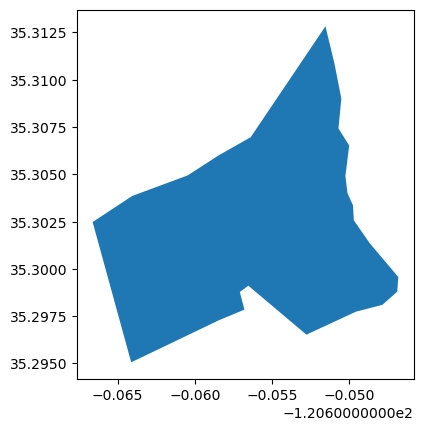

In [3]:
gdf.plot()

In [4]:
naip = get_naip(gdf_to_ee_poly(gdf))

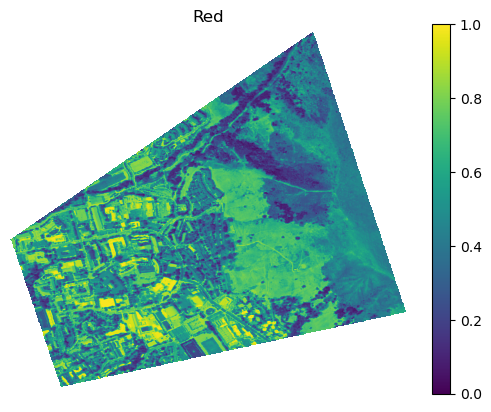

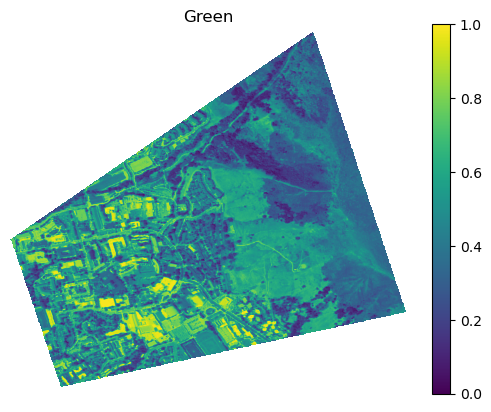

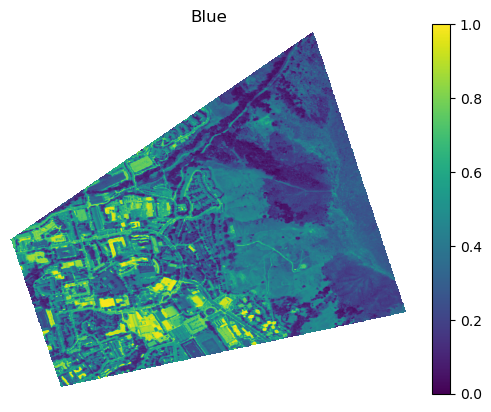

In [5]:
plt.imshow(naip[:,:,0]); plt.axis("off"); plt.colorbar(); plt.title("Red"); plt.show()
plt.imshow(naip[:,:,1]); plt.axis("off"); plt.colorbar(); plt.title("Green"); plt.show()
plt.imshow(naip[:,:,2]); plt.axis("off"); plt.colorbar(); plt.title("Blue"); plt.show()

In [6]:
s1 = get_s1(gdf_to_ee_poly(gdf))

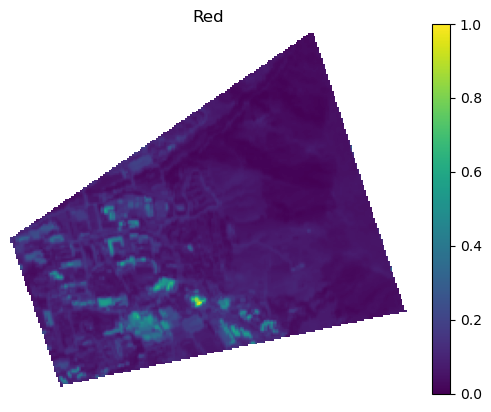

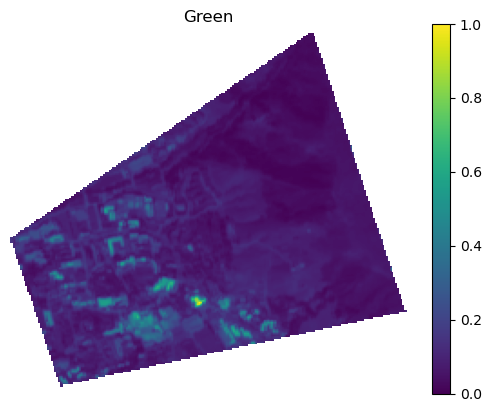

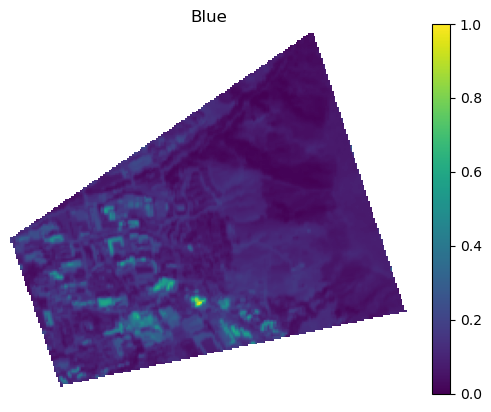

In [7]:
plt.imshow(s1[:,:,0]); plt.axis("off"); plt.colorbar(); plt.title("Red"); plt.show()
plt.imshow(s1[:,:,1]); plt.axis("off"); plt.colorbar(); plt.title("Green"); plt.show()
plt.imshow(s1[:,:,2]); plt.axis("off"); plt.colorbar(); plt.title("Blue"); plt.show()